In [85]:
import pandas as pd
import numpy as np
import xgboost as xgb 

loaded_model = xgb.XGBClassifier()
loaded_model.load_model('xgb_model_good.json')
cleaned_df = pd.read_csv('ufc_cleaned.csv')
fighters_df = pd.read_csv('ufc_fighters_cleaned.csv')
features_df = pd.read_csv('ufc_features.csv')

In [86]:
def getData(p1, p2, eventDate, ref): # Takes Two fighters, event date, and referee, and creates the features again for the model
    cols = ['height','weight','reach','SLpM','Str. Acc.', 'SApM','Str. Def','TD Avg.','TD Acc.','TD Def.','Sub. Avg.']
    
    row1 = fighters_df[fighters_df['name'] == p1]
    row2 = fighters_df[fighters_df['name'] == p2]

    if row1.empty or row2.empty:
        missing = p1 if row1.empty else p2
        raise ValueError(f"Fighter not found: {missing}")

    f1 = row1[cols].squeeze().to_numpy(dtype=float)
    f2 = row2[cols].squeeze().to_numpy(dtype=float)
    fighter_diff = f1 - f2


    #calculate age at event
    eventDate = pd.to_datetime(eventDate)
    p1Dob = pd.to_datetime(fighters_df.loc[fighters_df['name'] == p1, 'dob'].iloc[0])
    p2Dob = pd.to_datetime(fighters_df.loc[fighters_df['name'] == p2, 'dob'].iloc[0])
    p1Age = (eventDate - p1Dob).days / 365.25
    p2Age = (eventDate - p2Dob).days / 365.25
    ageDiff = p1Age - p2Age


    #calculate age adjusted stats
    age_adjust_cols = ['SLpM','Str. Acc.', 'SApM','Str. Def','TD Avg.','TD Acc.','TD Def.','Sub. Avg.']
    p1_age_adjusted = {}
    p2_age_adjusted = {}
    
    for col in age_adjust_cols:
        if col in row1.columns and col in row2.columns:
            p1_value = row1[col].squeeze()
            p2_value = row2[col].squeeze()
            
            # Apply age adjustment formula
            p1_age_adjusted[col] = p1_value * (1/p1Age)
            p2_age_adjusted[col] = p2_value * (1/p2Age)



    #find days since last fight
    p1_fights = cleaned_df[(cleaned_df['p1_fighter'] == p1) | (cleaned_df['p2_fighter'] == p1)]
    p2_fights = cleaned_df[(cleaned_df['p1_fighter'] == p2) | (cleaned_df['p2_fighter'] == p2)]
    
    p1_last = pd.to_datetime(p1_fights['event_date']).max() if not p1_fights.empty else pd.NaT
    p2_last = pd.to_datetime(p2_fights['event_date']).max() if not p2_fights.empty else pd.NaT
    
    p1_days = (eventDate - p1_last).days if pd.notnull(p1_last) else None
    p2_days = (eventDate - p2_last).days if pd.notnull(p2_last) else None
    days_diff = p1_days - p2_days


    #get stance and encode it
    stance1 = row1['stance'].squeeze()
    stance2 = row2['stance'].squeeze()
    categories = ['Open Stance', 'Orthodox', 'Sideways', 'Southpaw', 'Switch']
    stance1 = [True if stance1 == cat else False for cat in categories]
    stance2 = [True if stance2 == cat else False for cat in categories]


    #calculate records
    p1_win_fights = cleaned_df[((cleaned_df['p1_fighter'] == p1) & (cleaned_df['winner'] == 1)) | ((cleaned_df['p2_fighter'] == p1) & (cleaned_df['winner'] == 0))]
    p1_loss_fights = cleaned_df[((cleaned_df['p1_fighter'] == p1) & (cleaned_df['winner'] == 0)) | ((cleaned_df['p2_fighter'] == p1) & (cleaned_df['winner'] == 1))]

    p1_wins = len(p1_win_fights)
    p1_losses = len(p1_loss_fights)
    p1_total = p1_wins + p1_losses
    
    p2_win_fights = cleaned_df[((cleaned_df['p1_fighter'] == p2) & (cleaned_df['winner'] == 0)) | ((cleaned_df['p2_fighter'] == p2) & (cleaned_df['winner'] == 1))]
    p2_loss_fights = cleaned_df[((cleaned_df['p1_fighter'] == p2) & (cleaned_df['winner'] == 1)) | ((cleaned_df['p2_fighter'] == p2) & (cleaned_df['winner'] == 0))]

    p2_wins = len(p2_win_fights)
    p2_losses = len(p2_loss_fights)
    p2_total = p2_wins + p2_losses
    
    # Calculate differences
    win_diff = p1_wins - p2_wins
    loss_diff = p1_losses - p2_losses
    total_diff = p1_total - p2_total


    # calculate win streaks
    p1_past_fights = cleaned_df[
        (cleaned_df['event_date'].notna()) & 
        ((cleaned_df['p1_fighter'] == p1) | (cleaned_df['p2_fighter'] == p1))
    ].sort_values('event_date', ascending=False)
    
    p2_past_fights = cleaned_df[
        (cleaned_df['event_date'].notna()) & 
        ((cleaned_df['p1_fighter'] == p2) | (cleaned_df['p2_fighter'] == p2))
    ].sort_values('event_date', ascending=False)
    
    # Calculate p1's current win streak
    p1_win_streak = 0
    for _, fight in p1_past_fights.iterrows():
        # Check if p1 won this fight
        if (fight['p1_fighter'] == p1 and fight['winner'] == 1) or (fight['p2_fighter'] == p1 and fight['winner'] == 0):
            p1_win_streak += 1
        else:
            # Stop counting at first loss
            break
    
    # Calculate p2's current win streak
    p2_win_streak = 0
    for _, fight in p2_past_fights.iterrows():
        # Check if p2 won this fight
        if (fight['p1_fighter'] == p2 and fight['winner'] == 1) or (fight['p2_fighter'] == p2 and fight['winner'] == 0):
            p2_win_streak += 1
        else:
            # Stop counting at first loss
            break
    

    #referee
    ref_counts = (cleaned_df['referee'].value_counts()).get(ref, 0)


    #calculate EMA
    features = [
    'KD', 'SIG_STR_PCT', 'TD_PCT', 'SUB_ATT', 'REV', 'CTRL',
    'R1_KD', 'R1_SIG_STR_PCT', 'R1_TD_PCT', 'R1_SUB_ATT', 'R1_REV', 'R1_CTRL',
    'SIG_STR_PCT_DETAILED', 'R1_SIG_STR_PCT_DETAILED',
    'SIG_STR_LANDED', 'SIG_STR_ATTEMPTED', 'TOTAL_STR_LANDED', 'TOTAL_STR_ATTEMPTED',
    'TD_LANDED', 'TD_ATTEMPTED',
    'R1_SIG_STR_LANDED', 'R1_SIG_STR_ATTEMPTED', 'R1_TOTAL_STR_LANDED', 'R1_TOTAL_STR_ATTEMPTED',
    'R1_TD_LANDED', 'R1_TD_ATTEMPTED',
    'HEAD_LANDED', 'HEAD_ATTEMPTED', 'BODY_LANDED', 'BODY_ATTEMPTED',
    'LEG_LANDED', 'LEG_ATTEMPTED',
    'DISTANCE_LANDED', 'DISTANCE_ATTEMPTED', 'CLINCH_LANDED', 'CLINCH_ATTEMPTED',
    'GROUND_LANDED', 'GROUND_ATTEMPTED',
    'R1_HEAD_LANDED', 'R1_HEAD_ATTEMPTED', 'R1_BODY_LANDED', 'R1_BODY_ATTEMPTED',
    'R1_LEG_LANDED', 'R1_LEG_ATTEMPTED',
    'R1_DISTANCE_LANDED', 'R1_DISTANCE_ATTEMPTED', 'R1_CLINCH_LANDED', 'R1_CLINCH_ATTEMPTED',
    'R1_GROUND_LANDED', 'R1_GROUND_ATTEMPTED'
    ]   
    
    # Initialize dictionaries to store EMAs
    p1_emas = {}
    p2_emas = {}
    
    # Calculate EMAs for p1
    cleaned_df['event_date'] = pd.to_datetime(cleaned_df['event_date'])
    p1_prev_fights = cleaned_df[(cleaned_df['event_date'] < eventDate) & ((cleaned_df['p1_fighter'] == p1) | (cleaned_df['p2_fighter'] == p1))]
    p1_prev_fights = p1_prev_fights.sort_values('event_date', ascending=False).head(3)
    
    if not p1_prev_fights.empty:
        # Process each fight for p1
        for _, fight in p1_prev_fights.iterrows():
            position = 'p1' if fight['p1_fighter'] == p1 else 'p2'
            prefix = 'p1_' if position == 'p1' else 'p2_'
            
            # Extract feature values for this fight
            for feat in features:
                col_name = f"{prefix}{feat}"
                if col_name in fight and not pd.isna(fight[col_name]):
                    # Convert to numeric and add to list
                    if feat not in p1_emas:
                        p1_emas[feat] = []
                    
                    p1_emas[feat].append(pd.to_numeric(fight[col_name], errors='coerce'))

        for feat in features:
            if feat in p1_emas:
                if len(p1_emas[feat]) == 1:
                    # Only one fight, use that value
                    p1_emas[feat] = p1_emas[feat][0]
                elif len(p1_emas[feat]) == 2:
                    # Two fights, weight more recent fight higher (0.6, 0.4)
                    p1_emas[feat] = 0.6 * p1_emas[feat][0] + 0.4 * p1_emas[feat][1]
                elif len(p1_emas[feat]) >= 3:
                    # Three or more fights, use weights 0.5, 0.3, 0.2 for most recent to oldest
                    p1_emas[feat] = 0.5 * p1_emas[feat][0] + 0.3 * p1_emas[feat][1] + 0.2 * p1_emas[feat][2]
            else:
                p1_emas[feat] = np.nan
    
    # Calculate EMAs for p2
    p2_prev_fights = cleaned_df[(cleaned_df['event_date'] < eventDate) & 
                               ((cleaned_df['p1_fighter'] == p2) | (cleaned_df['p2_fighter'] == p2))]
    p2_prev_fights = p2_prev_fights.sort_values('event_date', ascending=False).head(3)
    
    if not p2_prev_fights.empty:
        # Process each fight for p2
        for _, fight in p2_prev_fights.iterrows():
            position = 'p1' if fight['p1_fighter'] == p2 else 'p2'
            prefix = 'p1_' if position == 'p1' else 'p2_'
            
            # Extract feature values for this fight
            for feat in features:
                col_name = f"{prefix}{feat}"
                if col_name in fight and not pd.isna(fight[col_name]):
                    # Convert to numeric and add to list
                    if feat not in p2_emas:
                        p2_emas[feat] = []
                    
                    p2_emas[feat].append(pd.to_numeric(fight[col_name], errors='coerce'))
        
        # Calculate simple weighted average for the last 3 fights (most recent has highest weight)
        for feat in features:
            if feat in p2_emas:
                if len(p2_emas[feat]) == 1:
                    # Only one fight, use that value
                    p2_emas[feat] = p2_emas[feat][0]
                elif len(p2_emas[feat]) == 2:
                    # Two fights, weight more recent fight higher (0.6, 0.4)
                    p2_emas[feat] = 0.6 * p2_emas[feat][0] + 0.4 * p2_emas[feat][1]
                elif len(p2_emas[feat]) >= 3:
                    # Three or more fights, use weights 0.5, 0.3, 0.2 for most recent to oldest
                    p2_emas[feat] = 0.5 * p2_emas[feat][0] + 0.3 * p2_emas[feat][1] + 0.2 * p2_emas[feat][2]
            else:
                p2_emas[feat] = np.nan
        
        feature_dict = {
        'winner': np.nan,  # Placeholder for prediction
        
        # Basic stats for fighter 1
        'p1_height': f1[0],
        'p1_weight': f1[1],
        'p1_reach': f1[2],
        'p1_slpm': f1[3],
        'p1_str_acc': f1[4],
        'p1_sapm': f1[5],
        'p1_str_def': f1[6],
        'p1_td_avg': f1[7],
        'p1_td_acc': f1[8],
        'p1_td_def': f1[9],
        'p1_sub_avg': f1[10],
        
        # Basic stats for fighter 2
        'p2_height': f2[0],
        'p2_weight': f2[1],
        'p2_reach': f2[2],
        'p2_slpm': f2[3],
        'p2_str_acc': f2[4],
        'p2_sapm': f2[5],
        'p2_str_def': f2[6],
        'p2_td_avg': f2[7],
        'p2_td_acc': f2[8],
        'p2_td_def': f2[9],
        'p2_sub_avg': f2[10],
        
        # Age and physical differences
        'p1_age_at_event': p1Age,
        'p2_age_at_event': p2Age,
        'height_diff': f1[0] - f2[0],
        'reach_diff': f1[1] - f2[1],
        'weight_diff': f1[2] - f2[2],
        'age_diff': ageDiff,
        
        # Skill differences
        'slpm_diff': f1[3] - f2[3],
        'stracc_diff': f1[4] - f2[4],
        'sapm_diff': f1[5] - f2[5],
        'strdef_diff': f1[6] - f2[6],
        'tdavg_diff': f1[7] - f2[7],
        'tdacc_diff': f1[8] - f2[8],
        'tddef_diff': f1[9] - f2[9],
        'subavg_diff': f1[10] - f2[10],
        
        # Time since last fight
        'p1_days_since_last_fight': p1_days,
        'p2_days_since_last_fight': p2_days,
        'days_since_last_fight_diff': days_diff,
        
        # Fight records
        'p1_wins': p1_wins,
        'p1_losses': p1_losses,
        'p1_total': p1_total,
        'p2_wins': p2_wins,
        'p2_losses': p2_losses,
        'p2_total': p2_total,
        'win_diff': win_diff,
        'loss_diff': loss_diff,
        'total_diff': total_diff,
        'p1_win_streak': p1_win_streak,
        'p2_win_streak': p2_win_streak,
        
        # Age adjusted stats
        'p1_age_adjusted_slpm': p1_age_adjusted['SLpM'],
        'p2_age_adjusted_slpm': p2_age_adjusted['SLpM'],
        'p1_age_adjusted_str_acc': p1_age_adjusted['Str. Acc.'],
        'p2_age_adjusted_str_acc': p2_age_adjusted['Str. Acc.'],
        'p1_age_adjusted_sapm': p1_age_adjusted['SApM'],
        'p2_age_adjusted_sapm': p2_age_adjusted['SApM'],
        'p1_age_adjusted_str_def': p1_age_adjusted['Str. Def'],
        'p2_age_adjusted_str_def': p2_age_adjusted['Str. Def'],
        'p1_age_adjusted_td_avg': p1_age_adjusted['TD Avg.'],
        'p2_age_adjusted_td_avg': p2_age_adjusted['TD Avg.'],
        'p1_age_adjusted_td_acc': p1_age_adjusted['TD Acc.'],
        'p2_age_adjusted_td_acc': p2_age_adjusted['TD Acc.'],
        'p1_age_adjusted_td_def': p1_age_adjusted['TD Def.'],
        'p2_age_adjusted_td_def': p2_age_adjusted['TD Def.'],
        'p1_age_adjusted_sub_avg': p1_age_adjusted['Sub. Avg.'],
        'p2_age_adjusted_sub_avg': p2_age_adjusted['Sub. Avg.']
    }
    
    # Add all EMA metrics for both fighters
    for feat in features:
        feature_dict[f'p1_{feat.lower()}_ema'] = p1_emas[feat]
        feature_dict[f'p2_{feat.lower()}_ema'] = p2_emas[feat]
    
    # Add stance encoding
    for i, stance_cat in enumerate(categories):
        feature_dict[f'p1_stance_{stance_cat}'] = stance1[i]
    for i, stance_cat in enumerate(categories):
        feature_dict[f'p2_stance_{stance_cat}'] = stance2[i]
    
    # Add referee frequency
    feature_dict['referee_freq'] = ref_counts

    # Convert to DataFrame
    prediction_df = pd.DataFrame([feature_dict])
    
    return prediction_df

def convert_to_american_odds(probability):
    if probability <= 0 or probability >= 1:
        raise ValueError("Probability must be between 0 and 1 exclusively")
    
    # For favorites (probability > 0.5)
    if probability > 0.5:
        odds = round(-100 * (probability / (1 - probability)))
        return f"{odds}"
    # For underdogs (probability <= 0.5)
    else:
        odds = round(100 * ((1 - probability) / probability))
        return f"+{odds}"

def predict_winner(p1, p2, eventDate, ref): # uses the features we calculated and inputs it into a model to get the outcome
    # Get feature data
    fight_features = getData(p1, p2, eventDate, ref)
    
    # Make prediction
    # Convert to float to ensure proper handling of numeric values
    fight_features_numeric = fight_features.drop(columns=['winner']).astype(float)
    prediction = loaded_model.predict_proba(fight_features_numeric)
    
    # Format results
    result = {
        'p1_name': p1,
        'p2_name': p2,
        'p1_win_probability': float(prediction[0][1]), # Probability fighter 1 wins
        'p2_win_probability': float(prediction[0][0]), # Probability fighter 2 wins
        'p1_american_odds': convert_to_american_odds(float(prediction[0][1])),
        'p2_american_odds': convert_to_american_odds(float(prediction[0][0])),
        'predicted_winner': p1 if prediction[0][1] > prediction[0][0] else p2
    }
    return result

prediction = predict_winner('Sodiq Yusuff', 'Mairon Santos', '2025-05-20', 'Jason Herzog')
print(f"Predicted winner: {prediction['predicted_winner']}")
print(f"{prediction['p1_name']} win probability: {prediction['p1_win_probability']:.2%}")
print(f"{prediction['p2_name']} win probability: {prediction['p2_win_probability']:.2%}")
print(f"{prediction['p1_name']} betting odds: {prediction['p1_american_odds']}")
print(f"{prediction['p2_name']} betting odds: {prediction['p2_american_odds']}")

Predicted winner: Mairon Santos
Sodiq Yusuff win probability: 47.69%
Mairon Santos win probability: 52.31%
Sodiq Yusuff betting odds: +110
Mairon Santos betting odds: -110


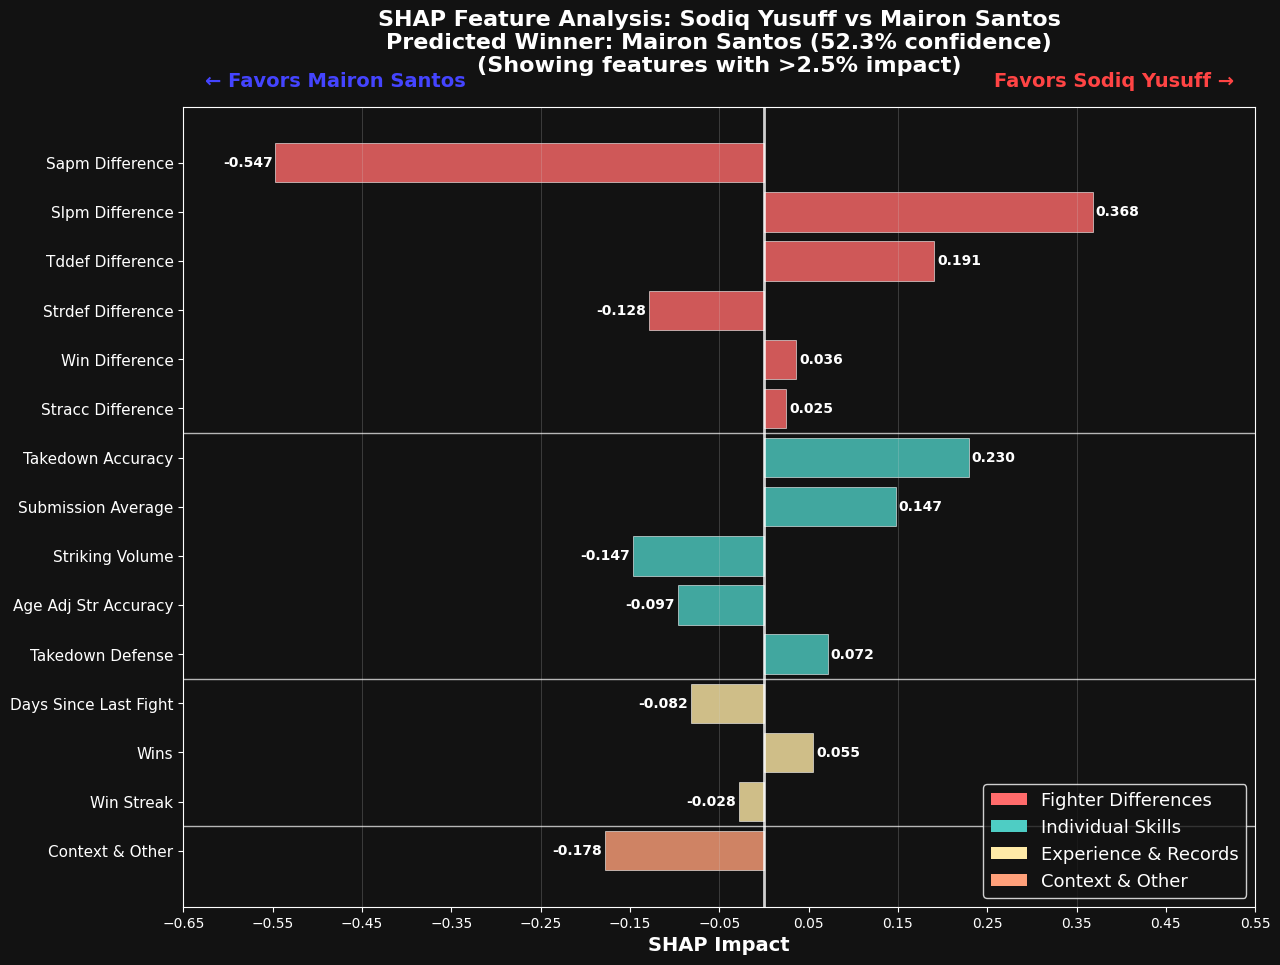

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_optimized_shap_visualization(p1_name, p2_name, event_date, referee, model):
    """
    Creates an optimized SHAP visualization with vertical lines at every other increment and category separators
    """
    fight_data = getData(p1_name, p2_name, event_date, referee)
    fight_features = fight_data.drop(columns=['winner']).astype(float)
    
    # Get SHAP values
    explainer = shap.Explainer(model)
    shap_explanation = explainer(fight_features)
    single_explanation = shap_explanation[0]
    
    if hasattr(single_explanation.values, 'shape') and len(single_explanation.values.shape) > 1:
        shap_values = single_explanation.values[:, 1]
    else:
        shap_values = single_explanation.values
    
    # INCREASED THRESHOLD to filter out very small impact features
    MIN_THRESHOLD = 0.025
    
    # Create feature mapping for combining p1/p2 stats
    combined_features = {}
    other_features = []
    other_shap_sum = 0
    processed_features = set()
    
    # Define stat categories to combine
    stat_categories = {
        'slpm': 'Striking Volume',
        'str_acc': 'Striking Accuracy', 
        'sapm': 'Striking Absorbed',
        'str_def': 'Striking Defense',
        'td_avg': 'Takedown Average',
        'td_acc': 'Takedown Accuracy',
        'td_def': 'Takedown Defense',
        'sub_avg': 'Submission Average',
        'age_adjusted_str_acc': 'Age Adj Str Accuracy',
        'age_adjusted_str_def': 'Age Adj Str Defense',
        'age_adjusted_td_acc': 'Age Adj TD Accuracy',
        'age_adjusted_td_def': 'Age Adj TD Defense',
        'age_adjusted_sub_avg': 'Age Adj Sub Average'
    }
    
    # Combine p1/p2 stats for Individual Skills
    for base_stat, display_name in stat_categories.items():
        p1_col = f'p1_{base_stat}'
        p2_col = f'p2_{base_stat}'
        
        p1_idx = None
        p2_idx = None
        
        for i, col in enumerate(fight_features.columns):
            if col == p1_col:
                p1_idx = i
            elif col == p2_col:
                p2_idx = i
        
        if p1_idx is not None and p2_idx is not None:
            combined_shap = shap_values[p1_idx] + shap_values[p2_idx]
            
            if abs(combined_shap) > MIN_THRESHOLD:
                p1_val = fight_features.iloc[0, p1_idx]
                p2_val = fight_features.iloc[0, p2_idx]
                
                combined_features[display_name] = {
                    'shap_value': combined_shap,
                    'p1_value': p1_val,
                    'p2_value': p2_val,
                    'category': 'Individual Skills'
                }
                
                processed_features.add(p1_col)
                processed_features.add(p2_col)
    
    # Combine Physical Attributes (only if meaningful)
    physical_combinations = [
        ('p1_age_at_event', 'p2_age_at_event', 'Age'),
        ('p1_reach', 'p2_reach', 'Reach'), 
        ('p1_height', 'p2_height', 'Height'),
        ('p1_weight', 'p2_weight', 'Weight')
    ]
    
    for p1_col, p2_col, display_name in physical_combinations:
        p1_idx = None
        p2_idx = None
        
        for i, col in enumerate(fight_features.columns):
            if col == p1_col:
                p1_idx = i
            elif col == p2_col:
                p2_idx = i
        
        if p1_idx is not None and p2_idx is not None:
            combined_shap = shap_values[p1_idx] + shap_values[p2_idx]
            
            if abs(combined_shap) > MIN_THRESHOLD:
                p1_val = fight_features.iloc[0, p1_idx]
                p2_val = fight_features.iloc[0, p2_idx]
                
                combined_features[display_name] = {
                    'shap_value': combined_shap,
                    'p1_value': p1_val,
                    'p2_value': p2_val,
                    'category': 'Physical Attributes'
                }
                
                processed_features.add(p1_col)
                processed_features.add(p2_col)
    
    # Combine Experience & Records
    experience_combinations = [
        ('p1_wins', 'p2_wins', 'Wins'),
        ('p1_losses', 'p2_losses', 'Losses'),
        ('p1_total', 'p2_total', 'Total Fights'),
        ('p1_win_streak', 'p2_win_streak', 'Win Streak'),
        ('p1_days_since_last_fight', 'p2_days_since_last_fight', 'Days Since Last Fight')
    ]
    
    for p1_col, p2_col, display_name in experience_combinations:
        p1_idx = None
        p2_idx = None
        
        for i, col in enumerate(fight_features.columns):
            if col == p1_col:
                p1_idx = i
            elif col == p2_col:
                p2_idx = i
        
        if p1_idx is not None and p2_idx is not None:
            combined_shap = shap_values[p1_idx] + shap_values[p2_idx]
            
            if abs(combined_shap) > MIN_THRESHOLD:
                p1_val = fight_features.iloc[0, p1_idx]
                p2_val = fight_features.iloc[0, p2_idx]
                
                combined_features[display_name] = {
                    'shap_value': combined_shap,
                    'p1_value': p1_val,
                    'p2_value': p2_val,
                    'category': 'Experience & Records'
                }
                
                processed_features.add(p1_col)
                processed_features.add(p2_col)
    
    # Process remaining features
    for i, feature in enumerate(fight_features.columns):
        if feature in processed_features:
            continue
            
        # Skip excluded features
        if feature in ['age_diff', 'days_since_last_fight_diff']:
            continue
        
        shap_val = shap_values[i]
        if abs(shap_val) > MIN_THRESHOLD:
            
            # Categorize remaining features
            category = 'Other'
            if '_diff' in feature:
                category = 'Fighter Differences'
            elif 'stance_' in feature:
                category = 'Fighting Style'
            elif feature == 'referee_freq':
                category = 'Context & Other'
            elif '_ema' in feature:
                category = 'Context & Other'
            
            if category == 'Other' or category == 'Context & Other':
                # Sum up miscellaneous features
                other_shap_sum += shap_val
            else:
                clean_name = feature.replace('_diff', ' Difference').replace('_', ' ').title()
                clean_name = clean_name.replace('p1 ', f'{p1_name} ').replace('p2 ', f'{p2_name} ')
                
                other_features.append({
                    'name': clean_name,
                    'shap_value': shap_val,
                    'value': fight_features.iloc[0, i],
                    'category': category
                })
    
    # Group features by category
    all_features_by_category = {
        'Fighter Differences': [],
        'Individual Skills': [],
        'Physical Attributes': [],
        'Experience & Records': [],
        'Fighting Style': [],
        'Context & Other': []
    }
    
    # Add combined features WITHOUT advantage indicators
    for name, data in combined_features.items():
        all_features_by_category[data['category']].append({
            'name': name,
            'shap_value': data['shap_value'],
            'category': data['category'],
            'type': 'combined',
            'p1_value': data['p1_value'],
            'p2_value': data['p2_value']
        })
    
    # Add other features
    for feature in other_features:
        all_features_by_category[feature['category']].append({
            'name': feature['name'],
            'shap_value': feature['shap_value'],
            'category': feature['category'],
            'type': 'individual'
        })
    
    # Add the combined "Context & Other" bar if meaningful
    if abs(other_shap_sum) > MIN_THRESHOLD:
        all_features_by_category['Context & Other'].append({
            'name': 'Context & Other',
            'shap_value': other_shap_sum,
            'category': 'Context & Other',
            'type': 'combined'
        })
    
    # Sort each category and take top features per category
    final_features = []
    category_colors = {
        'Fighter Differences': '#FF6B6B',
        'Individual Skills': '#4ECDC4',
        'Physical Attributes': '#96CEB4',
        'Experience & Records': '#FFEAA7',
        'Fighting Style': '#DDA0DD',
        'Context & Other': '#FFA07A'
    }
    
    # Limit features per category to prevent overcrowding
    category_limits = {
        'Fighter Differences': 6,
        'Individual Skills': 5,
        'Physical Attributes': 3,
        'Experience & Records': 3,
        'Fighting Style': 2,
        'Context & Other': 1
    }
    
    # Build the final ordered list GROUPED BY CATEGORY (not by absolute value)
    for category in ['Fighter Differences', 'Individual Skills', 'Physical Attributes',
                     'Experience & Records', 'Fighting Style', 'Context & Other']:
        category_features = all_features_by_category[category]
        if category_features:
            # Sort within category by absolute SHAP value
            category_features.sort(key=lambda x: abs(x['shap_value']), reverse=True)
            limit = category_limits[category]
            final_features.extend(category_features[:limit])
    
    # Take top 16 overall but maintain category grouping
    if len(final_features) > 16:
        # Proportionally reduce from each category
        temp_features = []
        for category in ['Fighter Differences', 'Individual Skills', 'Physical Attributes',
                         'Experience & Records', 'Fighting Style', 'Context & Other']:
            cat_features = [f for f in final_features if f['category'] == category]
            if cat_features:
                # Take proportional amount, minimum 1 per category
                proportion = max(1, int(len(cat_features) * 16 / len(final_features)))
                temp_features.extend(cat_features[:proportion])
        final_features = temp_features[:16]
    
    # Create the plot with proper margins
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(16, 10))
    fig.patch.set_facecolor('#121212')
    
    feature_names = [f['name'] for f in final_features]
    shap_vals = [f['shap_value'] for f in final_features]
    categories = [f['category'] for f in final_features]
    colors = [category_colors[cat] for cat in categories]
    
    # Create bars
    y_pos = np.arange(len(feature_names))
    bars = ax.barh(y_pos, shap_vals, color=colors, alpha=0.8, edgecolor='white', linewidth=0.5)
    
    # Customize the plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feature_names, fontsize=11, color='white')
    ax.invert_yaxis()
    ax.set_xlabel('SHAP Impact', color='white', fontsize=14, fontweight='bold')
    ax.axvline(0, color='white', linewidth=2, alpha=0.8)
    
    # REMOVE ALL GRID LINES (including horizontal ones)
    ax.grid(False)
    
    ax.set_facecolor('#121212')
    
    # Set x-axis increments to 0.1
    x_min, x_max = ax.get_xlim()
    # Extend range to nearest 0.1 increments
    x_min_rounded = np.floor(x_min * 10) / 10
    x_max_rounded = np.ceil(x_max * 10) / 10
    
    # Add margin for text
    margin = 0.05
    x_min_rounded -= margin
    x_max_rounded += margin
    
    ax.set_xlim(x_min_rounded, x_max_rounded)
    
    # Set x-axis ticks to 0.1 increments
    x_ticks = np.arange(x_min_rounded, x_max_rounded + 0.1, 0.1)
    ax.set_xticks(x_ticks)
    
    # Add light grey vertical lines at every OTHER increment (0.2, 0.4, 0.6, etc.)
    for i, tick in enumerate(x_ticks):
        if tick != 0 and i % 2 == 0:  # Every other increment, skipping 0
            ax.axvline(tick, color='lightgrey', linewidth=0.5, alpha=0.3)
    
    # Add clear direction indicators
    ax.text(0.02, 1.02, f'← Favors {p2_name}', transform=ax.transAxes, 
            color='#4444FF', fontsize=14, fontweight='bold', va='bottom')
    ax.text(0.98, 1.02, f'Favors {p1_name} →', transform=ax.transAxes, 
            color='#FF4444', fontsize=14, fontweight='bold', va='bottom', ha='right')
    
    # Add value labels with BETTER positioning to avoid border overlap and reduce spacing
    x_min, x_max = ax.get_xlim()
    x_range = x_max - x_min
    safe_margin = x_range * 0.02  # 2% safe margin from edges
    
    for i, (bar, val) in enumerate(zip(bars, shap_vals)):
        # REDUCED spacing between bar and label from 0.01 to 0.003
        if val > 0:
            label_x = val + 0.003  # Much closer to the bar
            # Ensure it doesn't go beyond safe boundary
            if label_x > x_max - safe_margin:
                label_x = x_max - safe_margin
            ha = 'left'
        else:
            label_x = val - 0.003  # Much closer to the bar
            # Ensure it doesn't go beyond safe boundary  
            if label_x < x_min + safe_margin:
                label_x = x_min + safe_margin
            ha = 'right'
            
        ax.text(label_x, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
               ha=ha, va='center', color='white', fontsize=10, fontweight='bold')
    
    # FIXED: Add horizontal lines between the main categories
    current_category = None
    separator_positions = []
    
    # First, identify where category changes occur
    for i, cat in enumerate(categories):
        if cat != current_category:
            if current_category is not None:
                # Record the position where category changes (between i-1 and i)
                separator_positions.append(i - 0.5)
            current_category = cat
    
    # Draw the separator lines at the correct positions
    for sep_pos in separator_positions:
        ax.axhline(y=sep_pos, color='white', linewidth=1, alpha=0.7)
    
    # Get prediction info
    prediction = model.predict_proba(fight_features)
    p1_prob = prediction[0][1]
    predicted_winner = p1_name if p1_prob > 0.5 else p2_name
    
    # Add title
    ax.set_title(f'SHAP Feature Analysis: {p1_name} vs {p2_name}\nPredicted Winner: {predicted_winner} ({max(p1_prob, 1-p1_prob):.1%} confidence)\n(Showing features with >{MIN_THRESHOLD:.1%} impact)', 
                color='white', fontsize=16, fontweight='bold', pad=25)
    
    # Create legend for categories that appear with larger font size
    from matplotlib.patches import Patch
    legend_elements = []
    seen_categories = []
    for cat in categories:
        if cat not in seen_categories:
            legend_elements.append(Patch(facecolor=category_colors[cat], label=cat))
            seen_categories.append(cat)
    
    ax.legend(handles=legend_elements, loc='lower right', facecolor='#121212', 
             edgecolor='white', fontsize=13)  # Larger font size
    
    ax.tick_params(colors='white')
    
    # Enhanced margins to prevent text cutoff
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, left=0.25, right=0.92, bottom=0.08)
    plt.show()

# Usage
create_optimized_shap_visualization('Sodiq Yusuff', 'Mairon Santos', '2025-05-20', 'Jason Herzog', loaded_model)